### >>>INGESTA DE DATOS

In [74]:
import psycopg2
import pandas as pd

# Credenciales de la base de datos
dbname = "DBInmerso"
user = "postgres"
password = "postgres"
host = "localhost"  # Cambia esto según tu configuración
port = "5432"

# Crear la cadena de conexión
connection_string = f"dbname={dbname} user={user} password={password} host={host} port={port}"

# Intentar establecer la conexión
try:
    connection = psycopg2.connect(connection_string)

    # Consulta para concatenar las tablas
    query_concatenar = """
        SELECT
            u.dni,
            u.nombre,
            u.apellido,
            u.edad,
            u.fecha_de_nacimiento,
            u.id_solicitud,
            u.usuario_solicitante,
            u.oficio_especial,
            r.ingresos,
            d.grado_dis,
            fn.tipo_fam_num,
            p.valoracion_patrimonio,
            p.coche,
            p.arrendador
        FROM
            usuarios u
        JOIN renta r ON u.dni = r.dni
        JOIN discapacidad d ON u.dni = d.dni
        JOIN familia_numerosa fn ON u.dni = fn.dni
        JOIN patrimonio p ON u.dni = p.dni;
    """

    # Crear un DataFrame con los resultados de la consulta concatenada
    df = pd.read_sql_query(query_concatenar, connection)

except Exception as e:
    print(f"Error al conectar a la base de datos: {e}")

finally:
    # Cerrar la conexión en el bloque 'finally' para asegurar que se cierre
    if connection:
        connection.close()


#>>>>>Ponderaciones<<<<<<#
edad_weight = 0.16666
discapacidad_weight = 0.1666
familia_weight = 0.1666
renta_wheigt = 0.16666
coche_wight = 0.16666
oficio_especial_wight = 0.166666
arrendador_wight = 0.16666

df

C:\Users\DELL\AppData\Local\Temp\ipykernel_19340\1587755063.py:44: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_concatenar, connection)


,dni,nombre,apellido,edad,fecha_de_nacimiento,id_solicitud,usuario_solicitante,oficio_especial,ingresos,grado_dis,tipo_fam_num,valoracion_patrimonio,coche,arrendador
0,95822412,Ruben,Noguera,62,1914-01-12,52,True,False,2767.0,2,0,2000000.0,False,False
1,46913810,Wilfredo,Duran,70,1949-02-17,458,True,True,4318.0,0,0,439183.0,False,True
2,28728463,Graciano,Carretero,61,1947-03-28,1386,False,True,4991.0,1,1,167742.0,True,True
3,83197857,Melisa,Carrillo,60,1932-12-22,1210,True,False,4806.0,0,1,124157.0,True,True
4,66629388,Flora,Costa,57,1924-06-20,62,False,False,3233.0,2,2,64249.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,69148126,Mamen,Zamorano,57,1950-01-08,57629,False,False,2944.0,1,2,291191.0,True,False
1496,45113084,Araceli,Medina,75,1913-09-18,51689,False,False,3319.0,2,2,417945.0,False,True
1497,80439867,Pablo,Villanueva,69,1934-12-29,1372,True,True,3404.0,0,0,42788.0,True,False
1498,55405943,Felicia,Dominguez,88,1915-06-02,1072,True,False,854.0,0,0,483367.0,False,False


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dni                    1500 non-null   object 
 1   nombre                 1500 non-null   object 
 2   apellido               1500 non-null   object 
 3   edad                   1500 non-null   int64  
 4   fecha_de_nacimiento    1500 non-null   object 
 5   id_solicitud           1500 non-null   int64  
 6   usuario_solicitante    1500 non-null   bool   
 7   oficio_especial        1500 non-null   bool   
 8   ingresos               1500 non-null   float64
 9   grado_dis              1500 non-null   int64  
 10  tipo_fam_num           1500 non-null   int64  
 11  valoracion_patrimonio  1500 non-null   float64
 12  coche                  1500 non-null   bool   
 13  arrendador             1500 non-null   bool   
dtypes: bool(4), float64(2), int64(4), object(4)
memory usage

### >>>EDAD.SCORE

In [76]:
def puntaje_edad_nueva(edad):
    if edad < 60:
        return 1
    elif 60 <= edad < 70:
        return 20
    elif 70 <= edad < 80:
        return 30
    else:  # Edad >= 80
        return 40

def procesar_edad(df):
    # Copiar el DataFrame para evitar modificar el original
    df_edad = df.copy()

    # Aplicar la función
    df_edad['score_edad'] = df_edad['edad'].apply(puntaje_edad_nueva)

    # Calcular el Min-Max Scaling 
    min_valor = df_edad['score_edad'].min()
    max_valor = df_edad['score_edad'].max()
    rango_deseado = 100
    min_deseado = 0

    df_edad['score_edad_scaled'] = ((df_edad['score_edad'] - min_valor) / (max_valor - min_valor)) * rango_deseado + min_deseado

    # Multiplicar 'score_edad_scaled' por el ponderador
    df_edad['score_edad_weighted'] = df_edad['score_edad_scaled'] * edad_weight
    
    # Devolver el DataFrame con las columnas seleccionadas
    return df_edad[['dni', 'edad', 'score_edad', 'score_edad_scaled','score_edad_weighted']].sort_values(by='dni')

# aplicar funcion
df_edad = procesar_edad(df)
df_edad


,dni,edad,score_edad,score_edad_scaled,score_edad_weighted
55,10076758,75,30,74.358974,12.392667
1290,10171954,58,1,0.000000,0.000000
1192,10196231,79,30,74.358974,12.392667
608,10209961,77,30,74.358974,12.392667
348,10344303,73,30,74.358974,12.392667
...,...,...,...,...,...
1472,99794603,86,40,100.000000,16.666000
144,99913412,70,30,74.358974,12.392667
1286,99929175,76,30,74.358974,12.392667
24,99949389,72,30,74.358974,12.392667


### >>>DISCAPACIDAD.SCORE

In [77]:
def puntaje_discapacidad(grado_dis):
    if grado_dis == 0:
        return 0
    elif grado_dis == 1:
        return 10
    else:  # grado_dis == 2
        return 20

def procesar_discapacidad(df):
    # Copiar el DataFrame para evitar modificar el original
    df_discapacidad = df.copy()

    # Aplicar la función 
    df_discapacidad['score_discapacidad'] = df_discapacidad['grado_dis'].apply(puntaje_discapacidad)

    # Calcular el Min-Max Scaling 
    min_valor = df_discapacidad['score_discapacidad'].min()
    max_valor = df_discapacidad['score_discapacidad'].max()
    rango_deseado = 100
    min_deseado = 0

    df_discapacidad['score_discapacidad_scaled'] = ((df_discapacidad['score_discapacidad'] - min_valor) / (max_valor - min_valor)) * rango_deseado + min_deseado

    df_discapacidad['score_discapacidad_weighted'] = df_discapacidad['score_discapacidad_scaled'] * discapacidad_weight
    
    # Devolver el DataFrame con las columnas seleccionadas
    return df_discapacidad[['dni', 'score_discapacidad', 'score_discapacidad_scaled','score_discapacidad_weighted']].sort_values(by='dni')

# aplicar funcion
df_discapacidad = procesar_discapacidad(df)
df_discapacidad

,dni,score_discapacidad,score_discapacidad_scaled,score_discapacidad_weighted
55,10076758,20,100.0,16.66
1290,10171954,10,50.0,8.33
1192,10196231,20,100.0,16.66
608,10209961,0,0.0,0.00
348,10344303,20,100.0,16.66
...,...,...,...,...
1472,99794603,10,50.0,8.33
144,99913412,0,0.0,0.00
1286,99929175,0,0.0,0.00
24,99949389,10,50.0,8.33


### >>>SCORE FAMILIA NUMEROSA

In [78]:
def puntaje_familia(tipo_fam_num):
    if tipo_fam_num == 0:
        return 0
    elif tipo_fam_num == 1:
        return 5
    else:  # tipo_fam_num == 2
        return 10

def procesar_familia(df):
    # Copiar el DataFrame para evitar modificar el original
    df_familia = df.copy()

    # Aplicar la función 
    df_familia['score_familia'] = df_familia['tipo_fam_num'].apply(puntaje_familia)

    # Calcular el Min-Max Scaling 
    min_valor = df_familia['score_familia'].min()
    max_valor = df_familia['score_familia'].max()
    rango_deseado = 100
    min_deseado = 0

    df_familia['score_familia_scaled'] = ((df_familia['score_familia'] - min_valor) / (max_valor - min_valor)) * rango_deseado + min_deseado

    df_familia['score_familia_weighted'] = df_familia['score_familia_scaled'] * familia_weight
    
    # Devolver el DataFrame con las columnas seleccionadas
    return df_familia[['dni', 'score_familia', 'score_familia_scaled','score_familia_weighted']].sort_values(by='dni')

# aplicar funcion
df_familia = procesar_familia(df)
df_familia

,dni,score_familia,score_familia_scaled,score_familia_weighted
55,10076758,0,0.0,0.00
1290,10171954,10,100.0,16.66
1192,10196231,10,100.0,16.66
608,10209961,5,50.0,8.33
348,10344303,5,50.0,8.33
...,...,...,...,...
1472,99794603,0,0.0,0.00
144,99913412,0,0.0,0.00
1286,99929175,10,100.0,16.66
24,99949389,0,0.0,0.00


### >>>COCHE - ARRENDADOR - OFICIO ESPECIAL

In [79]:
def puntaje_coche_arrendador_oficio(coche_arrendador_oficio):
    if coche_arrendador_oficio == True:
        return 100
    else:  #  == False
        return 0


def procesar_coche_arrendador_oficio(df):
    # Copiar el DataFrame para evitar modificar el original
    df_coche_arrendador_oficio = df.copy()

    # Aplicar la función 
    df_coche_arrendador_oficio['score_coche'] = df_coche_arrendador_oficio['coche'].apply(puntaje_coche_arrendador_oficio)
    df_coche_arrendador_oficio['score_arrendador'] = df_coche_arrendador_oficio['arrendador'].apply(puntaje_coche_arrendador_oficio)
    df_coche_arrendador_oficio['score_oficio_especial'] = df_coche_arrendador_oficio['oficio_especial'].apply(puntaje_coche_arrendador_oficio)


    df_coche_arrendador_oficio['score_coche_weighted'] = df_coche_arrendador_oficio['score_coche'] * coche_wight
    df_coche_arrendador_oficio['score_arrendador_weighted'] = df_coche_arrendador_oficio['score_arrendador'] * arrendador_wight
    df_coche_arrendador_oficio['score_oficio_especial_weighted'] = df_coche_arrendador_oficio['score_oficio_especial'] * oficio_especial_wight
     
    # Devolver el DataFrame con las columnas seleccionadas
    return df_coche_arrendador_oficio[['dni', 'score_coche', 'score_coche_weighted','score_arrendador','score_arrendador_weighted','score_oficio_especial', 'score_oficio_especial_weighted','fecha_de_nacimiento','id_solicitud' ]].sort_values(by='dni')


# aplicar funcion
df_coche_arrendador_oficio = procesar_coche_arrendador_oficio(df)
df_coche_arrendador_oficio

,dni,score_coche,score_coche_weighted,score_arrendador,score_arrendador_weighted,score_oficio_especial,score_oficio_especial_weighted,fecha_de_nacimiento,id_solicitud
55,10076758,0,0.000,0,0.000,100,16.6666,1942-02-28,1001
1290,10171954,0,0.000,0,0.000,0,0.0000,1944-05-31,791
1192,10196231,100,16.666,0,0.000,100,16.6666,1910-11-09,37351
608,10209961,100,16.666,100,16.666,0,0.0000,1940-03-28,33532
348,10344303,0,0.000,0,0.000,100,16.6666,1929-09-09,1487
...,...,...,...,...,...,...,...,...,...
1472,99794603,100,16.666,100,16.666,100,16.6666,1923-03-31,35037
144,99913412,0,0.000,100,16.666,0,0.0000,1929-06-04,547
1286,99929175,100,16.666,0,0.000,0,0.0000,1944-02-10,38236
24,99949389,0,0.000,100,16.666,0,0.0000,1930-07-27,51018


### >>>PATRIMONIO

### >>>MERGE 

In [85]:
#Merge de dataframes
score_merged = pd.merge(df_edad, df_discapacidad, on='dni', how='inner')\
              .merge(df_coche_arrendador_oficio, on='dni', how='inner')\
              .merge(df_familia, on='dni', how='inner')


# seleccion de columnas que terminan en '_weighted'
columnas_weighted = [col for col in score_merged.columns if col.endswith('_weighted')]

# Crea la nueva columna 'score_total' sumando todas las columnas '_weighted'
score_merged['score_total'] = score_merged[columnas_weighted].sum(axis=1)



score_merged = score_merged.sort_values(by='score_total', ascending=False)



#Seleccion de variables weighted y otras
score_merged_weighted = score_merged.loc[:, [
                                            'id_solicitud' ,
                                            'score_total',
                                            'score_edad_weighted',
                                            'score_discapacidad_weighted',
                                            'score_coche_weighted',
                                            'score_arrendador_weighted',
                                            'score_oficio_especial_weighted',
                                            'score_familia_weighted']]



score_merged_weighted_rename = {

    'id_solicitud': 'id_solicitud',
    'score_total': 'score',
    'score_edad_weighted': 'edad_score',
    'score_discapacidad_weighted': 'discapacidad_score',
    'score_coche_weighted': 'coche_score',
    'score_arrendador_weighted': 'arrendador_score',
    'score_oficio_especial_weighted': 'oficio_especial_score',
    'score_familia_weighted': 'familia_score'
    
}

# Renombrar todas las columnas
score_merged_weighted = score_merged_weighted.rename(columns=score_merged_weighted_rename)


score_merged_weighted

,id_solicitud,score,edad.score,discapacidad.score,coche.score,arrendador.score,oficio_especial.score,familia.score
259,1254,99.984600,16.666000,16.66,16.666,16.666,16.6666,16.66
972,1310,95.711267,12.392667,16.66,16.666,16.666,16.6666,16.66
1132,204,91.654600,16.666000,8.33,16.666,16.666,16.6666,16.66
574,366,91.654600,16.666000,8.33,16.666,16.666,16.6666,16.66
1177,2,91.654600,16.666000,8.33,16.666,16.666,16.6666,16.66
...,...,...,...,...,...,...,...,...
171,34412,0.000000,0.000000,0.00,0.000,0.000,0.0000,0.00
802,54811,0.000000,0.000000,0.00,0.000,0.000,0.0000,0.00
778,989,0.000000,0.000000,0.00,0.000,0.000,0.0000,0.00
796,52025,0.000000,0.000000,0.00,0.000,0.000,0.0000,0.00


### >>>EVALUACION DEL MODELO

In [81]:
score_merged_weighted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 259 to 110
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   dni                             1500 non-null   object 
 1   edad                            1500 non-null   int64  
 2   fecha_de_nacimiento             1500 non-null   object 
 3   id_solicitud                    1500 non-null   int64  
 4   score_edad_weighted             1500 non-null   float64
 5   score_discapacidad_weighted     1500 non-null   float64
 6   score_coche_weighted            1500 non-null   float64
 7   score_arrendador_weighted       1500 non-null   float64
 8   score_oficio_especial_weighted  1500 non-null   float64
 9   score_familia_weighted          1500 non-null   float64
 10  score_total                     1500 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 140.6+ KB


  Score Range  Número de Usuarios  Porcentaje
3        0-20                  60    4.000000
2       21-40                 332   22.133333
0       41-60                 681   45.400000
1       61-80                 361   24.066667
4      81-100                  59    3.933333


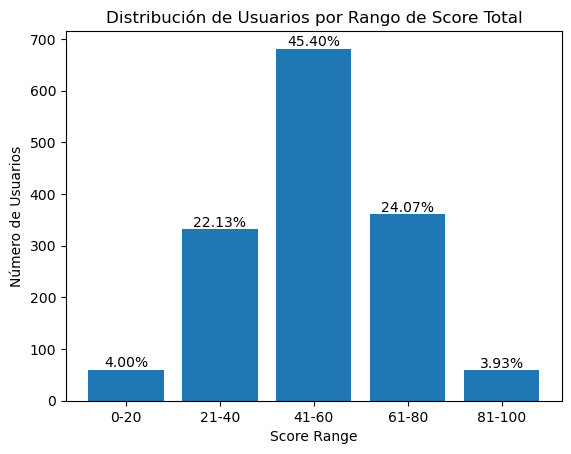

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear rangos para los puntajes
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']

# Agregar una nueva columna 'score_range' al DataFrame
score_merged_weighted['score_range'] = pd.cut(score_merged_weighted['score_total'], bins=bins, labels=labels)

# Contar usuarios por rango de score
usuarios_por_rango = score_merged_weighted['score_range'].value_counts().reset_index()

# Renombrar las columnas
usuarios_por_rango.columns = ['Score Range', 'Número de Usuarios']

# Calcular el porcentaje de usuarios en cada rango
total_usuarios = len(score_merged_weighted)
usuarios_por_rango['Porcentaje'] = (usuarios_por_rango['Número de Usuarios'] / total_usuarios) * 100

# Ordenar por 'Score Range'
usuarios_por_rango = usuarios_por_rango.sort_values('Score Range')

# Mostrar la tabla
print(usuarios_por_rango)

# Gráfico de barras para visualizar la distribución
plt.bar(usuarios_por_rango['Score Range'], usuarios_por_rango['Número de Usuarios'])
plt.title('Distribución de Usuarios por Rango de Score Total')
plt.xlabel('Score Range')
plt.ylabel('Número de Usuarios')

# Agregar porcentajes en el gráfico
for i, porcentaje in enumerate(usuarios_por_rango['Porcentaje']):
    plt.text(i, usuarios_por_rango['Número de Usuarios'].iloc[i] + 5, f'{porcentaje:.2f}%', ha='center')

plt.show()
